In [1]:
import pennylane as qml

In [2]:
from pennylane import numpy as np

In [3]:
# Array with all of the energies that are calculated
vqe_energies = []
# These are the distances I want to test
distances = [0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
print(distances)

[0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]


In [4]:
for dist in distances:
    # Defining all needed information for the generate_hamiltonian function
    name = 'h2-{:}'.format(dist)
    geometry = 'Hydrogen/h2-{:}.xyz'.format(dist)
    charge = 0
    multiplicity = 1
    basis_set = 'sto-3g'
    
    ###
    
    # Calling the generate_hamiltonian function from the pennylane module. Returns two values, h the hamiltonian and 
    # num_qubits the number of needed qubits
    h, num_qubits = qml.qchem.generate_hamiltonian(name, geometry, charge, multiplicity, basis_set, n_active_electrons = 2, n_active_orbitals = 2, mapping = 'jordan_wigner')
    
    ###
    
    # Defines the pqrticular quantum device to simulate qubit states. 'default.qubit' is a simple state simulator.
    dev = qml.device('default.qubit', wires = num_qubits)

    # Defines the circuit gates to allow optimization to be effective. Needs to be complex to prepare the ground state,
    # and simple enough to optimize.
    def circuit(params, wires):
        # Defines the initial basis of the qubits
        qml.BasisState(np.array([1, 1, 0, 0]), wires = wires)
        # Applies rotational gates on all wires with parameter i
        for i in wires:
            qml.Rot(*params[i], wires = i)
        # Applies CNOT entanglement gates
        qml.CNOT(wires = [2, 3])
        qml.CNOT(wires = [2, 0])
        qml.CNOT(wires = [3, 1])
    
    ###
    
    # Calling the VQECos function from the pennylane module. Returns the cost function of the optimization based on the
    # quantum circuit, the hamiltonian, and the simulator
    cost_function = qml.VQECost(circuit, h, dev)

    # This is the classical optimization work. Using gradiant descent with a step size of 0.4. Parameters are based on a
    # normal distribution about the center (0), with a spread (pi), and with an output of (num_quits * 3). 
    opt = qml.GradientDescentOptimizer(stepsize = 0.3)
    np.random.seed(0)
    params = np.random.normal(0, np.pi, (num_qubits, 3))
    
    ###
    
    max_iterations = 200
    # Convergence tolerance tells us how close we want the optimization to be
    conv_tol = 1e-06

    # Checks the cost of the random parameters
    current_energy = cost_function(params)
    for n in range(max_iterations):
        # Create new parameters based on the gradient descent optimizer using the cost_function by using the defined
        # stepsize on the original parameters
        params = opt.step(cost_function, params)
        # Caluculate the cost function of new parameters
        energy = cost_function(params)
        # Caluculate the convergence
        conv = np.abs(energy - current_energy)

        if n % 20 == 0:
            print('Iteration = {0}, Ground-state energy = {1} Ha, Convergence parameter = {2} Ha'.format(n, energy, conv))

        # If convergence is less than equal to convergence total stop
        if conv <= conv_tol:
            break
        
        current_energy = energy

    print('Final convergence parameter = {0} Ha'.format(conv))
    print('Final value of the ground-state energy = {0} Ha'.format(energy))
    print('Interatomic Distance: ', np.round(dist, 2), 'VQE Result: ', energy)
    print()
    
    # Adding all the energies to the string
    vqe_energies.append(energy)
    
    
    

Iteration = 0, Ground-state energy = -0.24111792565218804 Ha, Convergence parameter = 0.15615302517316965 Ha
Iteration = 20, Ground-state energy = -0.5992136560304644 Ha, Convergence parameter = 0.0005808210391480273 Ha
Iteration = 40, Ground-state energy = -0.6012432124244605 Ha, Convergence parameter = 8.048708167285312e-06 Ha
Iteration = 60, Ground-state energy = -0.6013438991337436 Ha, Convergence parameter = 4.178666692000732e-06 Ha
Iteration = 80, Ground-state energy = -0.6014201609654997 Ha, Convergence parameter = 3.507834363647433e-06 Ha
Iteration = 100, Ground-state energy = -0.6014842771736011 Ha, Convergence parameter = 2.946502723921718e-06 Ha
Iteration = 120, Ground-state energy = -0.6015380537135744 Ha, Convergence parameter = 2.4679938408489477e-06 Ha
Iteration = 140, Ground-state energy = -0.6015830403852656 Ha, Convergence parameter = 2.0622481959886585e-06 Ha
Iteration = 160, Ground-state energy = -0.6016205916121721 Ha, Convergence parameter = 1.719761317131585e-06 

Iteration = 60, Ground-state energy = -0.9542357888793673 Ha, Convergence parameter = 1.5109811175584298e-05 Ha
Iteration = 80, Ground-state energy = -0.9543320882907212 Ha, Convergence parameter = 9.832833721690193e-07 Ha
Final convergence parameter = 9.832833721690193e-07 Ha
Final value of the ground-state energy = -0.9543320882907212 Ha
Interatomic Distance:  1.9 VQE Result:  -0.9543320882907212

Iteration = 0, Ground-state energy = -0.7278113559569429 Ha, Convergence parameter = 0.015141607714051042 Ha
Iteration = 20, Ground-state energy = -0.9172651521281519 Ha, Convergence parameter = 0.0037658362717702953 Ha
Iteration = 40, Ground-state energy = -0.9426075604184829 Ha, Convergence parameter = 0.0002607848055515838 Ha
Iteration = 60, Ground-state energy = -0.9442586028690506 Ha, Convergence parameter = 1.67467447956815e-05 Ha
Iteration = 80, Ground-state energy = -0.9443666647821204 Ha, Convergence parameter = 1.1385676867980976e-06 Ha
Final convergence parameter = 9.964839503551

In [5]:
print(vqe_energies)

[-0.6016767176235871, -1.0550878225417577, -1.136145567127905, -1.1205320215049044, -1.0791734280821184, -1.0351734137119848, -0.9981406290284331, -0.9714199115717506, -0.9543320882907212, -0.9443676612660707, -0.9389159292608371, -0.9360483067711634]


In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

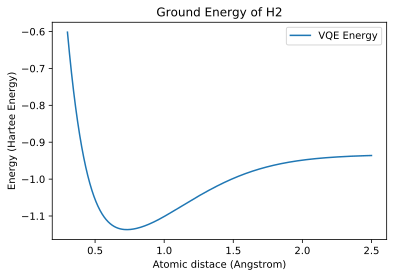

In [7]:
# Draws a plot of the ground energy of the H2 molecule based on the atomic distace
xnew = np.linspace(distances[0], distances[len(distances) - 1], 300) 

spl = make_interp_spline(distances, vqe_energies, k=5)
vqe_energy_smooth = spl(xnew)

plt.plot(xnew, vqe_energy_smooth, label = 'VQE Energy')
plt.xlabel('Atomic distace (Angstrom)')
plt.ylabel('Energy (Hartee Energy)')
plt.title('Ground Energy of H2')
plt.legend()
plt.show()